In [1]:
# Standard DS imports
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from sklearn import neighbors
from sklearn.svm import SVC
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import time

# All pytorch dependencies
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
import torch.nn as nn
import torch

# all tensorflow dependencies
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense
import tensorflow as tf
import keras

In [2]:
# # Load the TensorBoard notebook extension
# %load_ext tensorboard
# # Clear any logs from previous runs
# !rm -rf ./logs/

In [3]:
# Global var for selecting popularity cutoff
MINIMUM_POPULARITY_LIMIT = 40
MINIMUM_POPULARITY_PERCENTAGE = MINIMUM_POPULARITY_LIMIT / 100

In [7]:
# Initialize the DataFrame
if 'results_df' not in globals():
    results_df = pd.DataFrame(columns=['algorithm', 'accuracy', 'precision', 'recall', 'f1_score', 'AUPRC'])


def analyze_algorithm(y_true, y_pred, algorithm):
    global results_df

    # Calculate all scoring metrics
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {round(accuracy, 6)}")

    precision = precision_score(y_true, y_pred, average='macro')
    print(f"Precision: {round(precision, 6)}")

    recall = recall_score(y_true, y_pred, average='macro')
    print(f"Recall: {round(recall, 6)}")

    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"F1 Score: {round(f1, 6)}")

    precision_auc, recall_auc, _ = precision_recall_curve(y_true, y_pred)
    auprc = auc(recall_auc, precision_auc)
    print(f"AUPRC: {round(auprc, 6)}")

    # Create a temporary DataFrame for the new row
    new_row_df = pd.DataFrame({
        'algorithm': [algorithm],
        'accuracy': [round(accuracy, 6)],
        'precision': [round(precision, 6)],
        'recall': [round(recall, 6)],
        'f1_score': [round(f1, 6)],
        'AUPRC': [round(auprc, 6)]
    })

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(h_neg=260, h_pos=0, s=80, l=55, as_cmap=True)
    
    # Set the size of the plot
    plt.figure(figsize=(5, 4))
    
    # Calculate and plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, annot_kws={"size": 20})
    
    # Set the font size of labels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_ylabel('True Label', fontsize=16)
    
    # Define the labels
    labels = ['Negative', 'Positive']
    
    # Set the font size of the x and y tick labels and use proper labels
    ax.set_xticklabels(labels, fontsize=16)
    ax.set_yticklabels(labels, fontsize=16)
    
    # plt.show()


def print_correlation_matrix(dataframe):
    # Calculate correlation matrix
    corr_matrix = dataframe.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(h_neg=260, h_pos=0, s=80, l=55, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.show()


def predict_and_convert(model, x_data, y_data, cutoff):
    y_scores = model.predict(x_data)
    y_pred = (y_scores > cutoff).astype(int)
    y_data = (y_data > cutoff).astype(int)
    return y_data, y_pred


def find_best_kernel_value(is_classifier, x_train, y_train, x_test, y_test):
    k_values = range(1, 100, 4)
    train_scores = []
    test_scores = []
    scores_dict = {}

    for k in tqdm(k_values):
        model = neighbors.KNeighborsClassifier(k) if is_classifier else neighbors.KNeighborsRegressor(k)
        model.fit(x_train, y_train.values.ravel())

        y_train_predicted = model.predict(x_train)
        y_test_predicted = model.predict(x_test)

        if is_classifier:
            train_scores.append(f1_score(y_train, y_train_predicted, average='macro'))
            test_score = f1_score(y_test, y_test_predicted, average='macro')
        else:
            y_train_binary = (y_train >= MINIMUM_POPULARITY_LIMIT).astype(int)
            y_train_predicted_binary = (y_train_predicted >= MINIMUM_POPULARITY_LIMIT).astype(int)
            y_test_binary = (y_test >= MINIMUM_POPULARITY_LIMIT).astype(int)
            y_test_predicted_binary = (y_test_predicted >= MINIMUM_POPULARITY_LIMIT).astype(int)

            # Then, compute the accuracy
            train_scores.append(f1_score(y_train_binary, y_train_predicted_binary, average='macro'))
            test_score = f1_score(y_test_binary, y_test_predicted_binary, average='macro')

        test_scores.append(test_score)
        scores_dict[k] = test_score

    plt.plot(k_values, train_scores, 'r-s', label='Train')
    plt.plot(k_values, test_scores, 'b-o', label='Test')
    plt.legend()
    plt.show()

    best_k = max(scores_dict, key=scores_dict.get)
    print(f"The best k value is : {best_k} with score: {scores_dict[best_k]}")

    return best_k


@keras.saving.register_keras_serializable()
def f1_score_nn(y_true, y_pred):
    # Calculate Precision and Recall
    precision = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / K.sum(K.round(K.clip(y_pred, 0, 1)) + K.epsilon())
    recall = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / K.sum(K.round(K.clip(y_true, 0, 1)) + K.epsilon())

    # Calculate F1 Score
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1_val

dataset.csv read in successfully as a dataframe
Random Forest Classifier Training...
Random Forest Classifier Fitted

scores for the training set:
Accuracy: 0.992785
Precision: 0.993148
Recall: 0.991946
F1 Score: 0.992535
AUPRC: 0.993795

scores for the testing set:
Accuracy: 0.782018
Precision: 0.777905
Recall: 0.764653
F1 Score: 0.769175
AUPRC: 0.784341

Execution time: 11.095492839813232 seconds


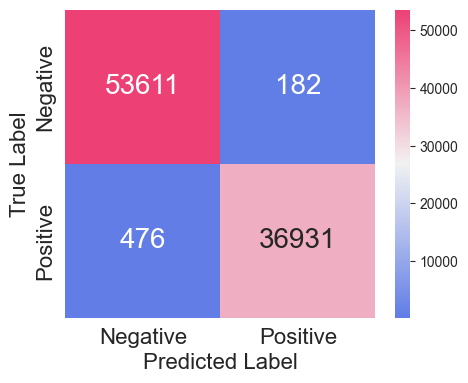

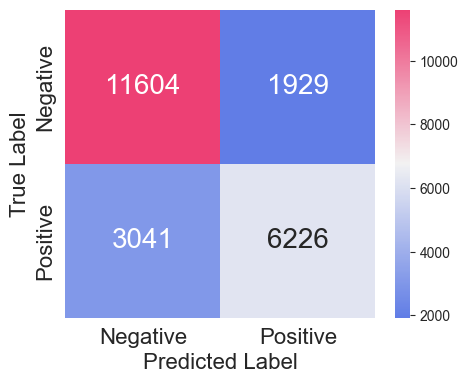

In [32]:
# Putting file specific info into arrays for easier access
files = ['dataset.csv']
inputs = [
    ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
     'instrumentalness', 'liveness','valence', 'tempo', 'time_signature'],

    ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
     'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
]
target = ['popularity']

start_time = time.time()

results_df = pd.DataFrame(columns=['algorithm', 'accuracy', 'precision', 'recall', 'f1_score', 'AUPRC'])

for i in range(len(files)):

    df = pd.read_csv('./' + files[i])
    print(files[i], 'read in successfully as a dataframe')
    # File specific cleaning

    # # Data cleaning for tracks.csv
    # if i == 0:
    #     df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year
    #     df = df.drop(columns=['id', 'name', 'artists', 'id_artists'])
    # 
    # # Data cleaning for dataset.csv
    # if i == 1:
    #     df['track_genre_encoded'] = LabelEncoder().fit_transform(df['track_genre'])
    #     df = df.drop(columns=['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'track_genre'])
    # 
    # print_correlation_matrix(df)
    # 
    # xtrain, xtest, ytrain, ytest = train_test_split(df[inputs[i]], df[target], test_size=0.2, random_state=42)
    # 
    # # Training Model 1 KNN-Regressor
    # kernelNumber = find_best_kernel_value(False, xtrain, ytrain, xtest, ytest)
    # 
    # print('KNN-Regressor Training...')
    # modelOne = neighbors.KNeighborsRegressor(kernelNumber)
    # modelOne.fit(xtrain, ytrain)
    # print('KNN-Regressor Fitted')
    # 
    # # Apply a same threshold to train predictions
    # y_train, y_train_pred = predict_and_convert(modelOne, xtrain, ytrain, MINIMUM_POPULARITY_LIMIT)
    # print('\nscores for the training set:')
    # analyze_algorithm(y_train, y_train_pred, files[i] + ' KNN-Regressor Training')
    # 
    # y_test, y_test_pred = predict_and_convert(modelOne, xtest, ytest, MINIMUM_POPULARITY_LIMIT)
    # print('\nscores for the testing set:')
    # analyze_algorithm(y_test, y_test_pred, files[i] + ' KNN-Regressor Testing')
    # 
    # # Training Model 2 KNN-Classifier
    # y_train_two = (ytrain > MINIMUM_POPULARITY_LIMIT).astype(int)
    # y_test_two = (ytest > MINIMUM_POPULARITY_LIMIT).astype(int)
    # 
    # kernelNumber = find_best_kernel_value(True, xtrain, y_train_two, xtest, y_test_two)
    # 
    # print('KNN-Classifier Training...')
    # modelTwo = neighbors.KNeighborsClassifier(kernelNumber)
    # modelTwo.fit(xtrain, y_train_two.values.ravel())
    # print('KNN-Classifier Fitted')
    # 
    # y_train_pred = modelTwo.predict(xtrain)
    # print('\nscores for the training set:')
    # analyze_algorithm(y_train_two, y_train_pred, files[i] + ' KNN-Classifier Training')
    # 
    # # Apply a same threshold to test predictions
    # y_test_pred = modelTwo.predict(xtest)
    # print('\nscores for the testing set:')
    # analyze_algorithm(y_test_two, y_test_pred, files[i] + ' KNN-Classifier Testing')
    # 
    # # Training Model 3 SVM-rbf
    # # The first dataset is too big to reasonably run with SVM as it generally take O(n^3*d) time for training
    # if i == 1:
    #     # Training Model 3 SVM
    #     print('YIIIIIPPPPPEEEEEEEEE')
    #     y_train = (ytrain > MINIMUM_POPULARITY_LIMIT).astype(int)
    #     y_test = (ytest > MINIMUM_POPULARITY_LIMIT).astype(int)
    # 
    #     sc = StandardScaler()
    #     X_train = sc.fit_transform(xtrain)
    #     X_test = sc.transform(xtest)
    # 
    #     # Training the SVM model on the Training set using a linear kernel
    #     print('SVM-Classifier Training...')
    #     modelThree = SVC(kernel='rbf', random_state=42)
    #     modelThree.fit(X_train, y_train.values.ravel())
    #     print('SVM-Classifier Fitted')
    # 
    #     # Predicting the results
    #     print('\nscores for the training set:')
    #     y_pred = modelThree.predict(X_train)
    #     analyze_algorithm(y_train, y_pred, files[i] + ' SVM Training')
    # 
    #     print('\nscores for the testing set:')
    #     y_pred = modelThree.predict(X_test)
    #     analyze_algorithm(y_test, y_pred, files[i] + ' SVM Testing')

    # Training Model 4 Convolution Neural Network
    X_train, X_test, y_train, y_test = train_test_split(df[inputs[i]], df[target], test_size=0.2, random_state=42)
    y_train = (y_train > MINIMUM_POPULARITY_LIMIT).astype(int)
    y_test = (y_test > MINIMUM_POPULARITY_LIMIT).astype(int)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')

    # # Define the neural network structure
    # modelFour = Sequential([
    #     Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    #     Dense(64, activation='relu'),
    #     Dense(64, activation='relu'),
    #     Dense(32, activation='relu'),
    #     Dense(1, activation='sigmoid')
    # ])
    # 
    # # Compile the model
    # modelFour.compile(optimizer='adam',
    #                   loss='binary_crossentropy',
    #                   metrics=[f1_score_nn])
    # 
    # y_train_numpy = y_train.to_numpy().astype('int64')
    # unique_classes, class_counts = np.unique(y_train_numpy, return_counts=True)
    # class_weights_dict = {class_label: len(y_train_numpy) / count for class_label, count in
    #                       zip(unique_classes, class_counts)}
    # 
    # # Define EarlyStopping and ModelCheckpoint callbacks.
    # es = EarlyStopping(monitor='val_f1_score_nn', mode='max', verbose=1, patience=15)
    # mc = ModelCheckpoint('best_model.keras', monitor='val_f1_score_nn', mode='max', verbose=1, save_best_only=True,
    #                      save_format='tf')
    # # callbacks=[es, mc]
    # 
    # log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    # # callbacks=[tensorboard_callback, es, mc]
    # # Pass class weights and callbacks into model.fit().
    # modelFour.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=100,
    #               class_weight=class_weights_dict, callbacks=[es, mc])
    # 
    # # Load the best model
    # modelFour = keras.models.load_model('best_model.keras')
    # 
    # # Make predictions
    # predictions = modelFour.predict(X_test)
    # plt.hist(predictions, bins=20)
    # plt.xlabel('Predicted probabilities')
    # plt.ylabel('Count')
    # plt.show()
    # 
    # predictions = (modelFour.predict(X_train) > MINIMUM_POPULARITY_PERCENTAGE).astype("int64")
    # print('\nscores for the Training set:')
    # analyze_algorithm(y_train, predictions, files[i] + ' Neural Network Training')
    # 
    # predictions = (modelFour.predict(X_test) > MINIMUM_POPULARITY_PERCENTAGE).astype("int64")
    # print('\nscores for the Testing set:')
    # analyze_algorithm(y_test, predictions, files[i] + ' Neural Network Testing')
    # 
    # # Training Model 5 Decision Tree Classifier
    # modelFive = DecisionTreeClassifier()
    # print('Decision Tree Classifier Training...')
    # modelFive.fit(X_train, y_train.values.ravel())
    # print('Decision Tree Classifier Fitted')
    # 
    # y_train_pred = modelFive.predict(X_train)
    # print('\nscores for the training set:')
    # analyze_algorithm(y_train, y_train_pred, files[i] + ' Decision Tree Classifier Training')
    # 
    # y_test_pred = modelFive.predict(X_test)
    # print('\nscores for the testing set:')
    # analyze_algorithm(y_test, y_test_pred, files[i] + ' Decision Tree Classifier Testing')

    # Training Model 6 Random Forest Classifier
    modelSix = RandomForestClassifier(n_estimators=500, n_jobs=-1)
    print('Random Forest Classifier Training...')
    modelSix.fit(X_train, y_train.values.ravel())
    print('Random Forest Classifier Fitted')

    y_train_pred = modelSix.predict(X_train)
    print('\nscores for the training set:')
    analyze_algorithm(y_train, y_train_pred, files[i] + ' Random Forest Classifier Training')

    y_test_pred = modelSix.predict(X_test)
    print('\nscores for the testing set:')
    analyze_algorithm(y_test, y_test_pred, files[i] + ' Random Forest Classifier Testing')

# End timing and print the result
end_time = time.time()

print("\nExecution time: {} seconds".format(end_time - start_time))

results_df.to_csv('resultsof'+str(MINIMUM_POPULARITY_LIMIT)+'.csv', index=False)


In [48]:
selected_row = df[(df['Unnamed: 0'] == 71108) & (df['track_id'] == '37ZJ0p5Jm13JPevGcx4SkF')]
selected_row

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
71108,71108,37ZJ0p5Jm13JPevGcx4SkF,Bon Jovi,Slippery When Wet,Livin' On A Prayer,85,249293,False,0.532,0.887,...,-3.757,1,0.0335,0.0778,0.000214,0.294,0.795,122.511,4,metal


In [49]:
selected_columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

In [51]:
selected_data = selected_row[selected_columns].copy()
selected_data.columns = selected_columns

In [52]:
prediction = modelSix.predict(selected_data)


In [53]:
print(prediction)

[1.]


In [54]:
probability = modelSix.predict_proba(selected_data)
print(probability)

[[0.26505 0.73495]]


The model is 0.73 confident that the song is over the threshold

In [55]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials


auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

# Function to search and fetch tracks and their audio features
def search_tracks(sp, track_name, artist_name):
    query = f'track:{track_name} artist:{artist_name}'
    results = sp.search(q=query, type='track', limit=50)
    tracks = results['tracks']['items']

    while results['tracks']['next']:  # Handling pagination
        results = sp.next(results['tracks'])
        tracks.extend(results['tracks']['items'])

    track_data = []
    for track in tracks:
        audio_features = sp.audio_features(track['id'])[0]
        if audio_features:
            selected_columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                                'time_signature']
            features = {feature: audio_features[feature] for feature in selected_columns if feature in audio_features}

            track_info = {
                'Track ID': track['id'],
                'Track Name': track['name'],
                'Artist Names': ', '.join(artist['name'] for artist in track['artists']),
                'Album': track['album']['name'],
                'Release Date': track['album']['release_date'],
                'Popularity': track['popularity']
            }
            track_info.update(features)
            track_data.append(track_info)

    return track_data

# Replace 'Track Name' and 'Artist Name' with actual search terms
track_name = "In the Air Tonight"
artist_name = "Phil Collins"
matched_tracks = search_tracks(sp, track_name, artist_name)

# Creating a DataFrame
df_tracks = pd.DataFrame(matched_tracks)


In [56]:
df_tracks

,Track ID,Track Name,Artist Names,Album,Release Date,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,18AXbzPzBS8Y3AkgSxzJPb,In The Air Tonight - 2015 Remastered,Phil Collins,Face Value (Deluxe Editon),1981-01-01,77,0.446,0.239,0,-13.945,1,0.0316,0.5510,0.000004,0.0697,0.2980,189.507,4
1,63WVeFX5l2UHPhLlQv0ipB,In the Air Tonight,Phil Collins,R-Kive,2014-09-30,48,0.429,0.233,0,-14.292,1,0.0337,0.5380,0.000003,0.0556,0.2680,189.567,4
2,6MjfEIHOMW6MaDO3LpFcmW,In the Air Tonight - 2015 Remaster,Phil Collins,Face Value (2016 Remaster),1981-01-01,52,0.452,0.238,0,-14.175,1,0.0316,0.5030,0.000006,0.0745,0.3360,189.999,4
3,4fjWMAvvpx1dgq3pnCm8Wt,In the Air Tonight - 2015 Remaster,Phil Collins,The Singles (Expanded),2016-10-14,40,0.453,0.242,0,-14.193,1,0.0324,0.5670,0.000004,0.0728,0.3110,189.223,4
4,0izmGVy9X7JVY3Eh44s84B,In the Air Tonight - Live from the Serious Tou...,Phil Collins,Serious Hits...Live! (2019 Remaster),1990-07-15,43,0.523,0.716,0,-7.113,1,0.0431,0.1340,0.000243,0.9880,0.2220,98.619,4
5,52Ei7VWJ3D5d1AYZMXOCMl,In The Air Tonight - Live,Phil Collins,Face Value (Deluxe Editon),1981-01-01,41,0.492,0.413,1,-9.424,0,0.0267,0.3230,0.000080,0.9850,0.0601,96.159,4
6,7kJ0UkAMhWvu7bbJDJo7cr,In the Air Tonight - '88 Remix,Phil Collins,Remixed Sides,2019-05-31,38,0.637,0.389,2,-11.451,0,0.0260,0.6210,0.000009,0.0773,0.3170,94.764,4
7,3QOuWFKX8OKyBrXiYxPakc,In the Air Tonight - Ben Liebrand Extended Ver...,"Phil Collins, Ben Liebrand",Remixed Sides,2019-05-31,38,0.755,0.329,2,-15.881,1,0.0456,0.0194,0.023800,0.1190,0.6670,94.741,4
8,0lLTc1wmgU3dE2xDZCkWVU,In the Air Tonight - 2015 Remaster,Phil Collins,The Singles,2016-10-14,28,0.452,0.238,0,-14.175,1,0.0316,0.5030,0.000006,0.0745,0.3360,189.999,4
9,5OXWepbxlFwfvwd7jOfMF6,"In The Air Tonight - Live at Live Aid, John F....",Phil Collins,"Live Aid (Live, 13th July 1985)",2018-08-24,28,0.299,0.790,2,-5.626,0,0.0771,0.8920,0.000394,0.9840,0.1910,94.269,4


In [57]:
selected_row2 = df_tracks[(df_tracks['Track ID'] == '18AXbzPzBS8Y3AkgSxzJPb')]
selected_row2

,Track ID,Track Name,Artist Names,Album,Release Date,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,18AXbzPzBS8Y3AkgSxzJPb,In The Air Tonight - 2015 Remastered,Phil Collins,Face Value (Deluxe Editon),1981-01-01,77,0.446,0.239,0,-13.945,1,0.0316,0.551,0.000004,0.0697,0.298,189.507,4


In [58]:
selected_data1 = selected_row2[selected_columns].copy()
selected_data1.columns = selected_columns
prediction = modelSix.predict(selected_data1)

print(prediction)
probability = modelSix.predict_proba(selected_data1)
print(probability)

[0.]
[[0.5662 0.4338]]


Even though this song is 0.77 popularity, which is above the 0.4 threshold, because it doesn't follow the modern trend of energetic music its not considered popular.
Now lets try this on a song that didnt exist when the data was selected for training.

In [59]:
# Replace 'Track Name' and 'Artist Name' with actual search terms
track_name = "Fortnight"
artist_name = "Taylor Swift"
matched_tracks = search_tracks(sp, track_name, artist_name)

# Creating a DataFrame
df_tracks = pd.DataFrame(matched_tracks)

df_tracks

,Track ID,Track Name,Artist Names,Album,Release Date,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,6dODwocEuGzHAavXqTbwHv,Fortnight (feat. Post Malone),"Taylor Swift, Post Malone",THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024-04-19,92,0.670,0.395,11,-10.924,1,0.0249,0.534,0.000007,0.0981,0.279,95.983,4
1,2OzhQlSqBEmt7hmkYxfT6m,Fortnight (feat. Post Malone),"Taylor Swift, Post Malone",THE TORTURED POETS DEPARTMENT,2024-04-18,94,0.675,0.397,11,-10.895,1,0.0245,0.499,0.000006,0.0939,0.319,95.988,4
2,5ggbblU7Tn5hz3cDTTFXxS,Fortnight (feat. Post Malone),"Taylor Swift, Post Malone",THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024-04-19,74,0.671,0.392,11,-10.920,1,0.0256,0.519,0.000010,0.0902,0.286,95.989,4
3,4bwUcvcJKDIOQJJt426nJG,Fortnight (feat. Post Malone),"Taylor Swift, Post Malone",THE TORTURED POETS DEPARTMENT,2024-04-18,66,0.503,0.402,11,-10.963,1,0.0297,0.507,0.000008,0.1020,0.304,192.151,4


In [60]:
selected_row3 = df_tracks[(df_tracks['Track ID'] == '2OzhQlSqBEmt7hmkYxfT6m')]
selected_data2 = selected_row3[selected_columns].copy()
selected_data2.columns = selected_columns
prediction = modelSix.predict(selected_data2)

print(prediction)
probability = modelSix.predict_proba(selected_data2)
print(probability)

[1.]
[[0.40726667 0.59273333]]


It predicts that its popular, but just barely. This shows that it won't be as accurate on data outside the time period the data was collected from. This is because of popular music characteristics changing over time and evolving.

Now just for fun lets test my favorite song

In [61]:
# Replace 'Track Name' and 'Artist Name' with actual search terms
track_name = "Wow"
artist_name = "Post Malone"
matched_tracks = search_tracks(sp, track_name, artist_name)

# Creating a DataFrame
df_tracks = pd.DataFrame(matched_tracks)

df_tracks

,Track ID,Track Name,Artist Names,Album,Release Date,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,7xQAfvXzm3AkraOtGPWIZg,Wow.,Post Malone,Hollywood's Bleeding,2019-09-06,81,0.829,0.539,11,-7.359,0,0.2080,0.13600,0.000002,0.103,0.388,99.960,4
1,0aMiATaLkj7ffT4W9Ng0TM,Wow.,Post Malone,Hollywood's Bleeding,2019-09-06,51,0.842,0.545,11,-7.289,0,0.2390,0.13200,0.000000,0.102,0.381,99.991,4
2,0fcq51a3gOI6gPvzc0YLsk,Wow. - Remix,"Post Malone, Roddy Ricch, Tyga",Wow. (Remix),2019-03-15,59,0.797,0.640,11,-6.272,0,0.1940,0.14800,0.000000,0.209,0.486,100.002,4
3,2HfFu2QCNnJiTAWs6KTRmC,Wow.,Post Malone,The Diamond Collection (Deluxe),2023-04-21,41,0.828,0.542,11,-7.264,0,0.1720,0.13800,0.000001,0.103,0.375,99.985,4
4,1reWqUNMwp5ciYLIufmWLI,Wow. - Instrumental,Post Malone,Wow. (Instrumental),2019-03-14,39,0.849,0.312,1,-10.535,1,0.0613,0.04110,0.895000,0.103,0.494,99.997,4
5,7LDvZV0Ki4TJqfxaNwopY7,Wow. (feat. Roddy Ricch & Tyga) - Remix,"Post Malone, Roddy Ricch, Tyga","NOW That's What I Call Music, Vol. 71",2019-08-02,25,0.819,0.626,11,-6.835,0,0.1680,0.14600,0.000000,0.147,0.478,99.987,4
6,6uaMQSQ7ftrewuhGxazBaL,Wow.,Post Malone,Best Rap Workout 2023,2023-09-20,20,0.833,0.539,11,-7.398,0,0.1780,0.16200,0.000002,0.101,0.385,99.947,4
7,4SHd8WywRkBhkpr3Y37jx3,Wow.,Post Malone,Love Game,2023-08-24,15,0.833,0.539,11,-7.398,0,0.1780,0.16200,0.000002,0.101,0.385,99.947,4
8,56xk7yHgzP5ylimWjNRieC,Wow.,Post Malone,Summer Hip Hop Hits 2023,2023-08-23,12,0.834,0.545,11,-7.289,0,0.2090,0.13200,0.000000,0.102,0.386,100.008,4
9,66T1RHEiZp8uEy6yHGuhAm,Wow.,Post Malone,The Diamond Collection (Deluxe),2023-04-21,12,0.830,0.555,11,-7.112,0,0.1580,0.13400,0.000002,0.105,0.358,100.002,4


In [62]:
selected_row3 = df_tracks[(df_tracks['Track ID'] == '7xQAfvXzm3AkraOtGPWIZg')]
selected_data2 = selected_row3[selected_columns].copy()
selected_data2.columns = selected_columns
prediction = modelSix.predict(selected_data2)

print(prediction)
probability = modelSix.predict_proba(selected_data2)
print(probability)

[0.]
[[0.51352031 0.48647969]]


This model still has a ways to go. But for having created it in under 10 weeks shows just how powerful it can be if trained on more data from more time periods and genres